In [1]:
import numpy as np
from numpy.linalg import norm

In [2]:
from tilelowrankmdd.solver.ipalm import ipalm
from tilelowrankmdd.utils.prox import prox_Fro
from tilelowrankmdd.mdd.mdd_fact import x2qqt_global

In [3]:
import matplotlib.pyplot as plt

In [4]:
dat = np.load('../../data/pup_pdown_overthrust.npz', allow_pickle=True)

pup_f   = dat['pup']

pdown_f = dat['pdown']

nt = 1600

In [5]:
ret = []
tol = 2e-4
ifstart, ifend = 0, 540
ns, nr = pdown_f[0].shape
nk = nr//4 

lam = (0.0, 0.1)

for ilam in lam:
    proxlist=[prox_Fro(ilam)]
    for idx in range(ifstart, ifend):
        ia = pdown_f[idx]
        ib = pup_f[idx]
        coupled_H = x2qqt_global(ia, nk)
    
        x0 = np.eye(nr, nk) +  np.eye(nr, nk)*1j
        tau_guess = [norm(ia, 'fro')**2]
        
        x1 = ipalm(coupled_H, ib, proxlist, [x0.ravel(),], tau_guess, tol)
    
        ret.append(x1[0])

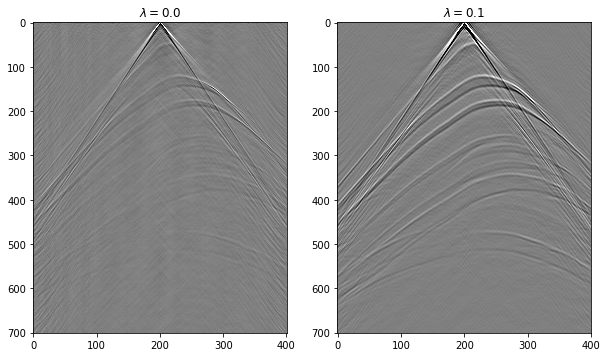

In [6]:
fig, axs = plt.subplots(1,2, figsize=(10,8))
pclip = 0.05

ret = np.array(ret).reshape(ifend*2, nr, nk)
dat = np.matmul(ret, ret.transpose(0,2,1))

for idx, idat in enumerate((dat[:ifend], dat[ifend:])):
    g1 = np.fft.irfft(idat, n=nt, axis=0)

    g1 = g1[:701, 201] 
    cc = np.abs(g1).max()
    axs[idx].imshow(g1, aspect=0.7, vmin=-cc*pclip, vmax=cc*pclip, cmap="gray")
    title = '$\lambda=%s$'%lam[idx]
    axs[idx].set_title(title)